In [3]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier

def open_pkl(pkl_file):
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)    
    return data

%cd /Users/lauram/Documents/M3/Projecte/M3-18.19/notebook/original

/Users/lauram/Documents/M3/Projecte/M3-18.19/notebook/original


Let us first read the train and test files

In [4]:
train_images_filenames = open_pkl('train_images_filenames.dat')
test_images_filenames = open_pkl('test_images_filenames.dat')
train_labels = open_pkl('train_labels.dat')
test_labels = open_pkl('test_labels.dat')

We create a SIFT object detector and descriptor

In [5]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [12]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [7]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=128, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [8]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

In [14]:
words

array([ 94,  77,  41, 103, 107,   4,  41,  41,  82,  99, 127,   4,  86,
         4, 103,  20,  54, 127,  31,  31, 120,  54,  75,  75,  63,  31,
       111,   4,  25,  31,  75, 120, 120,  75,   4,  68,  63,  94,  42,
         7,  66, 120,  50,  41,   4,  61,  86, 120,  28, 127,  15,  11,
       120, 120, 120, 120, 120, 120, 115,  87,  62, 127,  82,  31,  82,
       120, 120, 120, 115, 115,  41,  31,  94,  60,  82,  70, 120,  11,
        99,  18, 118,  41,  23,  61,  61,  31,  82,  90,  54, 127,  82,
        17,  54,  32, 111,  31,  61, 127,   3,  90,  68,  32, 107,   3,
        32,  82,  32,   3,  26,  41,  42,  26,   3,  61, 107, 127,  96,
       120, 106,  31, 118,  42,  54,  31,  35,  90, 106,  52,   8,  90,
        52,  69, 103,  82,  67,   4,  31,  60,  41, 115,  92, 115, 103,
        28,  61,  90,  92, 120, 120, 115, 115,  42,  41, 120,  11,  90,
        44,  52,  52,  60,  52,  69,  28,  82,  92, 120,   3,  69, 120,
       115,  52,  82,  68,   4,  82,  35,  68,  52,  82,  60,  2

We build a k-nn classifier and train it with the train descriptors

In [9]:
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [10]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [11]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

54.770755885997524


In [23]:
from matplotlib import pyplot as plt

In [35]:
valuues = np.arange(50, 1000, 50)
axis=np.arange(0,19,1)
valuues

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])

In [36]:
axis

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

Text(0,0.5,'Accuracy')

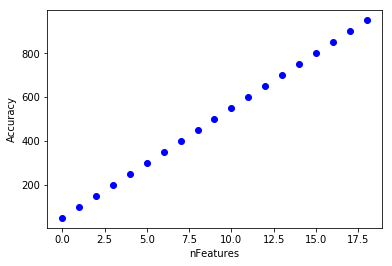

In [37]:
plt.plot(valuues, 'bo')
plt.xlabel('nFeatures')
plt.ylabel('Accuracy')
